In [1]:
import pandas as pd
import requests

# Load the Human Protein Atlas data
df = pd.read_csv("/data/ep924610/project_nb/paper_code/proteinatlas_4ef89daa.tsv", sep="\t")

# Gene list for filtering
gene_list = pd.read_csv("/data/ep924610/project_nb/paper_code/heatmap_results/skin_results.csv")["Gene"].to_list()

# Filter dataframe for genes in the gene list
df_filtered_genes = df[df['Gene'].isin(gene_list)]

# Initialize the Score columns
df_filtered_genes['HPA_Score'] = 0
df_filtered_genes['UniProt_Score'] = 0

# Assign HPA_Score based on 'Protein class' and 'Subcellular location'
df_filtered_genes.loc[
    df_filtered_genes['Protein class'].str.contains('Predicted membrane proteins', case=False, na=False), 
    'HPA_Score'
] = 1
df_filtered_genes.loc[
    df_filtered_genes['Subcellular location'].str.contains('Plasma membrane', case=False, na=False), 
    'HPA_Score'
] = 2

# Function to fetch subcellular location from UniProt
def fetch_uniprot_subcellular_location(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.xml"
    response = requests.get(url)
    if response.status_code == 200:
        # Parse the XML to find subcellular location
        if 'Plasma membrane' in response.text or 'Cell membrane' in response.text:
            return 2
    return 0

# Fetch UniProt data and assign UniProt_Score
df_filtered_genes['UniProt_Score'] = df_filtered_genes['Uniprot'].apply(fetch_uniprot_subcellular_location)

# Define a function to calculate the Final_Score based on the specified criteria
def calculate_final_score(row):
    hpa_score = row['HPA_Score']
    uniprot_score = row['UniProt_Score']
    
    if hpa_score == 2 and uniprot_score == 2:
        return 10
    elif uniprot_score == 2 and hpa_score == 1:
        return 8
    elif hpa_score == 2 and uniprot_score == 0:
        return 7
    elif uniprot_score == 2 and hpa_score == 0:
        return 7
    elif hpa_score == 1 and uniprot_score == 0:
        return 5
    else:
        return 0

# Calculate the Final_Score
df_filtered_genes['Final_Score'] = df_filtered_genes.apply(calculate_final_score, axis=1)

# Sort the dataframe by the Final_Score column in descending order
df_sorted = df_filtered_genes.sort_values(by='Final_Score', ascending=False)

# Count how many genes have each final score
score_counts = df_sorted['Final_Score'].value_counts()

# Print the counts for each score
print("Counts for each final score:")
print(score_counts)

# Print the final score for GPNMB
gpnmb_score = df_sorted.loc[df_sorted['Gene'] == 'GPNMB', 'Final_Score']
if not gpnmb_score.empty:
    print(f"\n Final_Score for GPNMB is: {gpnmb_score.iloc[0]}")
else:
    print("\nGPNMB is not in the gene list.")

# Save the results to a CSV file
output_file = "/data/ep924610/project_nb/paper_code/Protein_Atlas_results/gene_scores_skin.csv"
df_sorted[['Gene', 'HPA_Score', 'UniProt_Score', 'Final_Score']].to_csv(output_file, index=False)
df_sorted.to_csv(output_file)

/tmp/ipykernel_2907451/1115941977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_genes['HPA_Score'] = 0
/tmp/ipykernel_2907451/1115941977.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_genes['UniProt_Score'] = 0
/tmp/ipykernel_2907451/1115941977.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Counts for each final score:
Final_Score
0     6963
5     1487
7     1207
8      540
10     450
Name: count, dtype: int64

 Final_Score for GPNMB is: 8


In [4]:
df_sorted[df["Gene"] == "GPNMB"]

/tmp/ipykernel_2907451/1470731280.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sorted[df["Gene"] == "GPNMB"]


,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Cancer prognostics - Rectum Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (validation),Cancer prognostics - Skin Cuteneous Melanoma (TCGA),Cancer prognostics - Stomach Adenocarcinoma (TCGA),Cancer prognostics - Testicular Germ Cell Tumor (TCGA),Cancer prognostics - Thyroid Carcinoma (TCGA),Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA),HPA_Score,UniProt_Score,Final_Score
6900,GPNMB,"HGFIN, NMB",ENSG00000136235,Glycoprotein nmb,Q14956,7,23235967-23275108,"Disease related genes, Human disease related g...",NaN,NaN,...,unprognostic (1.51e-2),unprognostic (1.14e-1),unprognostic (1.61e-1),unprognostic (5.18e-3),unprognostic (1.04e-1),unprognostic (4.75e-1),unprognostic (1.90e-2),1,2,8


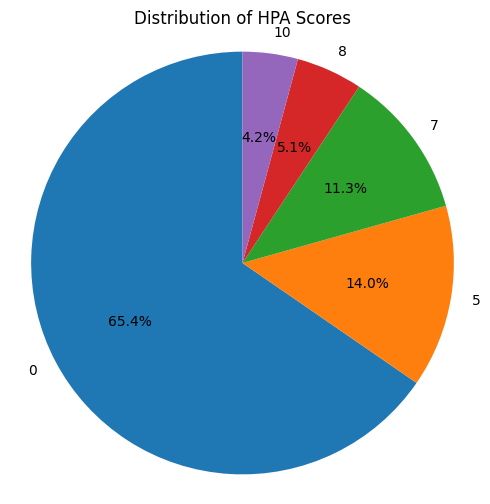

In [3]:
import matplotlib.pyplot as plt
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    score_counts,
    labels=score_counts.index,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Optional: Custom colors
)
plt.title("Distribution of HPA Scores")
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
plt.show()